# TEST 1:

In [1]:
# Add the 'src' as root folder, to find other modules in the project
import sys
sys.path.append("../")

In [2]:
# local imports 
from simulator.swing_equation import swing_equation

In [3]:
# external imports
import torch
import os
import pandas as pd
import numpy as np

from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.utils import BoxUniform, posterior_nn
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import kurtosis, skew



/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks-1/.venv/lib64/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define the experimental setup variables
num_simulations = [100, 1000, 10000, 25000, 50000, 100000]
T = 10
dt = 0.01
param_names = ['c1', 'c2', 'P0', 'P1', 'epsilon']

# Define output directories for results
dir_path_plots = '../../results/total_simulations/plots/'
dir_path_tables = '../../results/total_simulations/csv/'

# Create the directories
os.makedirs(dir_path_plots, exist_ok=True)
os.makedirs(dir_path_tables, exist_ok=True)

# Define the prior distribution for the parameters
prior_low = torch.tensor([0.1, 1.0, 0.1, 40.0, 0.1])
prior_high = torch.tensor([10.0, 100.0, 10.0, 70.0, 10.0])

prior = BoxUniform(low=prior_low, high=prior_high)

# Simulation parameters
simulator = swing_equation
proposal = prior
num_workers = 20
simulation_batch_size = 50
seed = None
show_progress_bar = True

# Density estimator parameters
model = 'maf'
hidden_features = 50
num_transforms = 10
z_score_x = 'independent'
z_score_theta = 'independent'
num_bins = 10
num_components = 10

# Define the true parameters for training and evaluation
theta_true = torch.tensor([4.0, 40.0, 3.0, 60.0, 7.0])

# Wrap the simulator to allow for total time and timestep change
def simulator(parameters):
    return swing_equation(parameters, dt=dt, T=T)

In [5]:
# Simulate the observation
observation = swing_equation(theta_true)

# Wrap the simulator function for compatibility with SBI
simulator, prior = prepare_for_sbi(swing_equation, prior)

posteriors = []

for total in num_simulations:

    # Wrap the simulator function for compatibility with SBI
    simulator, prior = prepare_for_sbi(simulator, prior)

    # Instantiate the neural density estimator
    neural_posterior = posterior_nn(
        model=model, 
        hidden_features=hidden_features, 
        num_transforms=num_transforms, 
        num_bins=num_bins, 
        num_components=num_components, 
        z_score_theta=z_score_theta, 
        z_score_x=z_score_x
    )

    # Set up the inference procedure with the SNPE procedure
    inference = SNPE(prior=prior)

    # Run the inference procedure to generate samples and corresponding simulated data points
    theta, x = simulate_for_sbi(
        simulator=simulator, 
        proposal=proposal, 
        num_simulations=total, 
        num_workers=num_workers, 
        simulation_batch_size=simulation_batch_size, 
        seed=seed, 
        show_progress_bar=show_progress_bar
    )

    # Train the neural density estimator
    density_estimator = inference.append_simulations(theta, x).train()

    # Build the posterior for the given parameters
    posterior = inference.build_posterior(density_estimator)

    posterior.set_default_x(observation)

    posteriors.append((posterior, total))

Running 100 simulations in 2 batches.: 100%|██████████| 2/2 [00:11<00:00,  5.64s/it]


 Neural network successfully converged after 177 epochs.

Running 1000 simulations in 20 batches.: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


 Neural network successfully converged after 70 epochs.

Running 10000 simulations in 200 batches.: 100%|██████████| 200/200 [00:33<00:00,  5.93it/s]


 Neural network successfully converged after 94 epochs.

Running 25000 simulations in 500 batches.:   0%|          | 0/500 [00:00<?, ?it/s]/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks-1/.venv/lib64/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running 25000 simulations in 500 batches.: 100%|██████████| 500/500 [00:49<00:00, 10.07it/s]


 Neural network successfully converged after 141 epochs.

Running 50000 simulations in 1000 batches.: 100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


 Neural network successfully converged after 60 epochs.

Running 100000 simulations in 2000 batches.: 100%|██████████| 2000/2000 [03:03<00:00, 10.90it/s]


 Neural network successfully converged after 202 epochs.

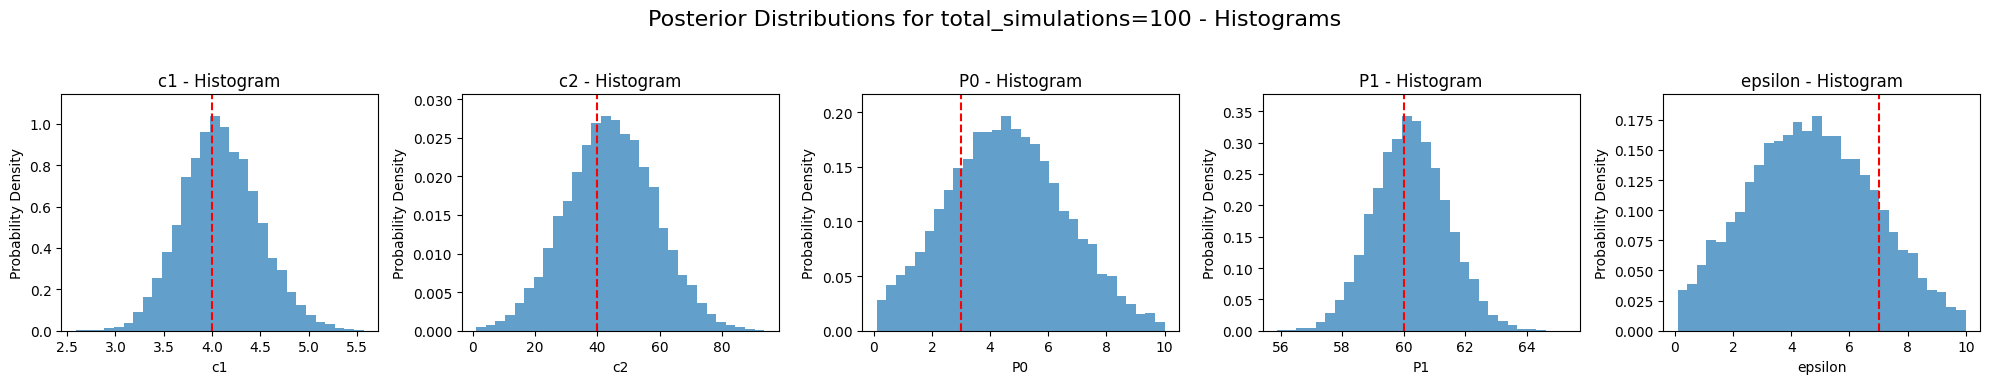

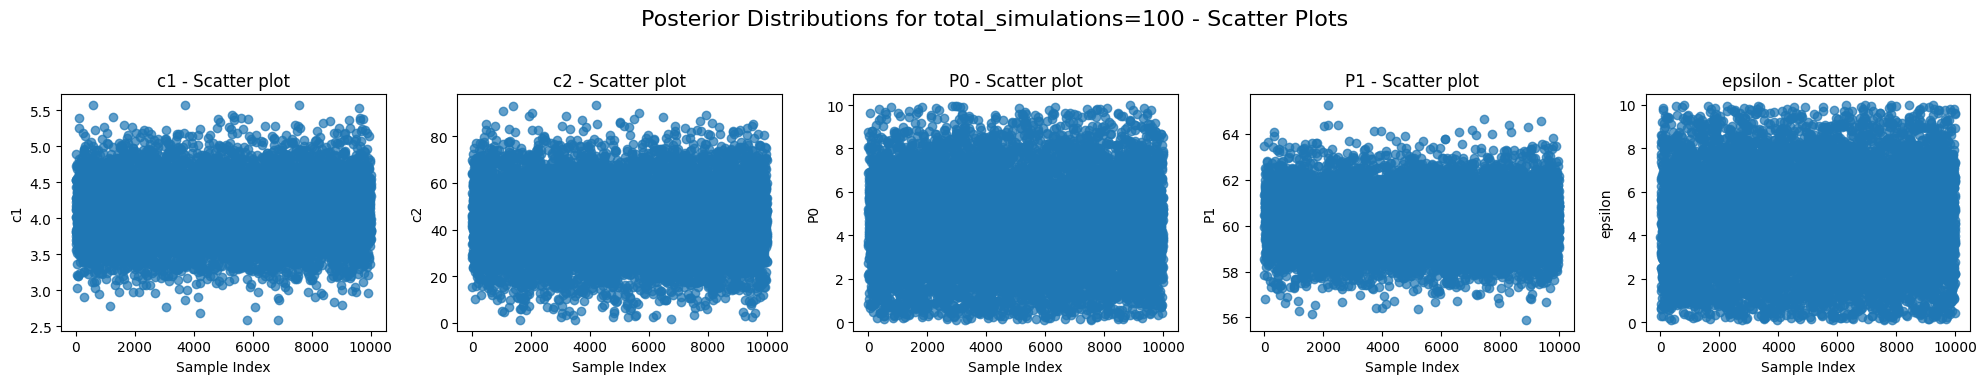

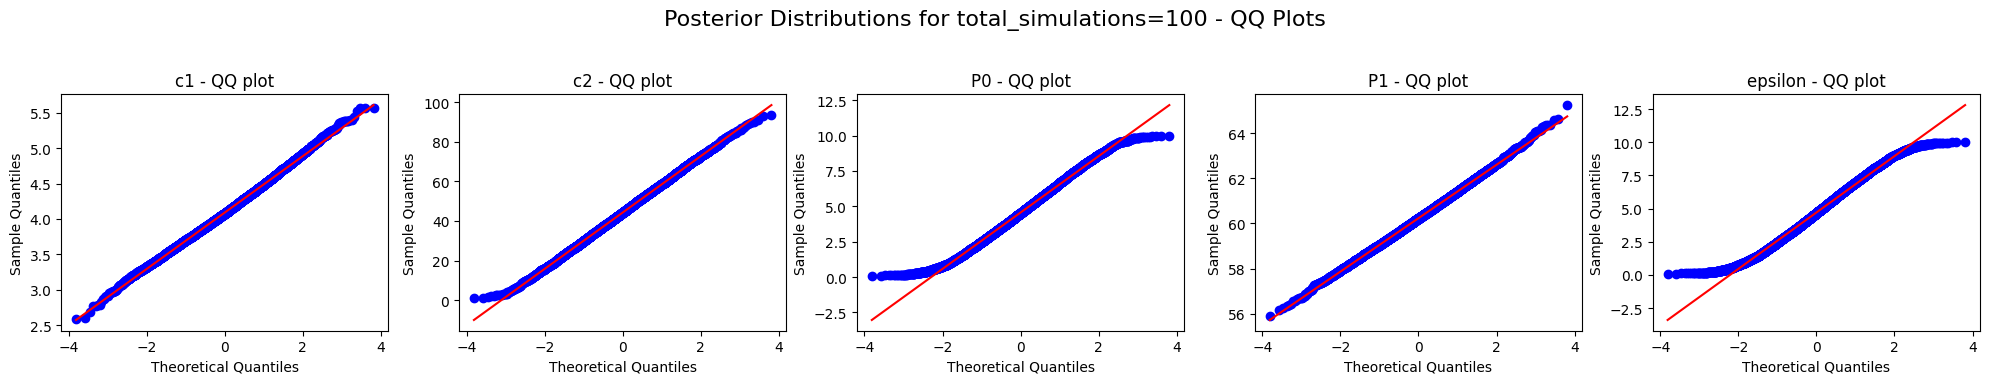

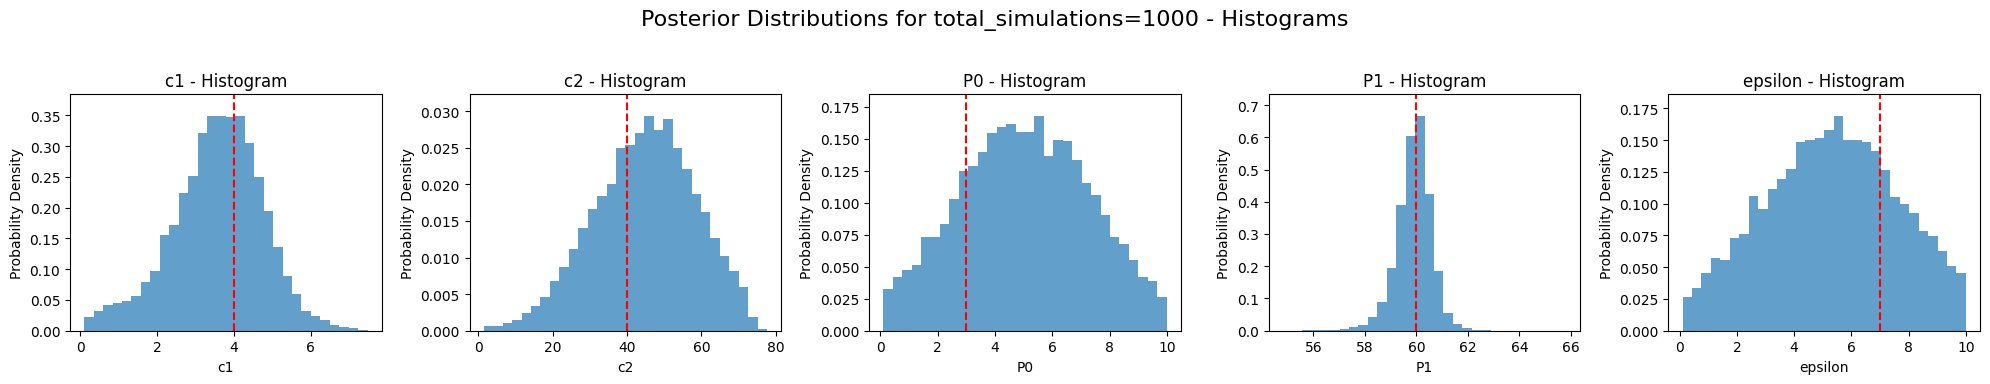

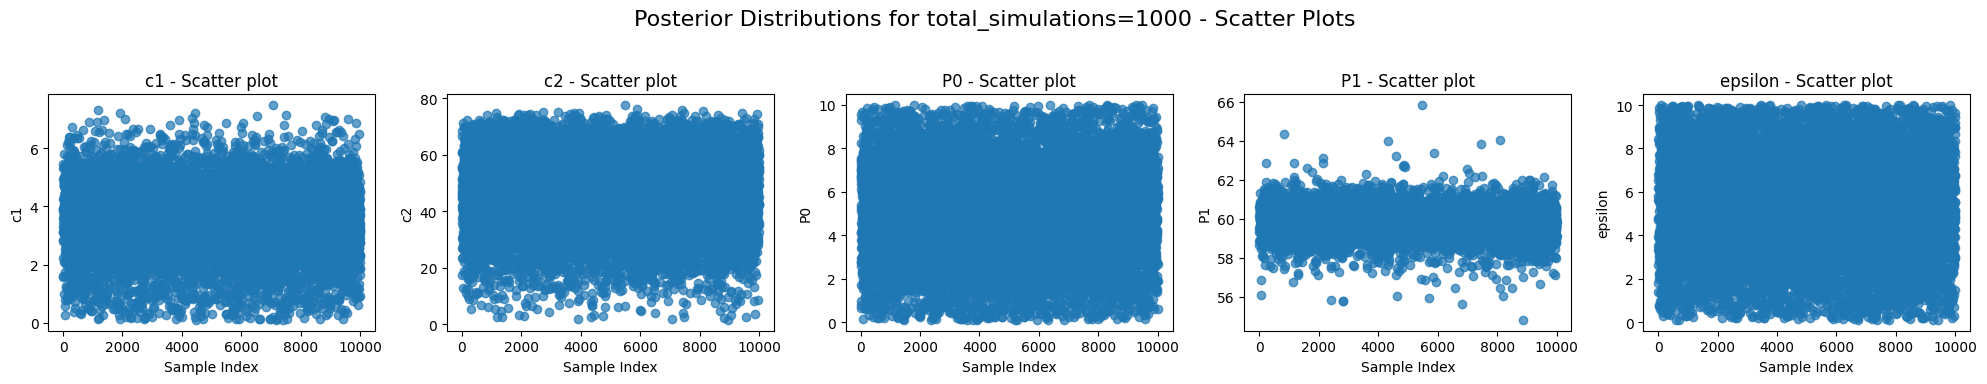

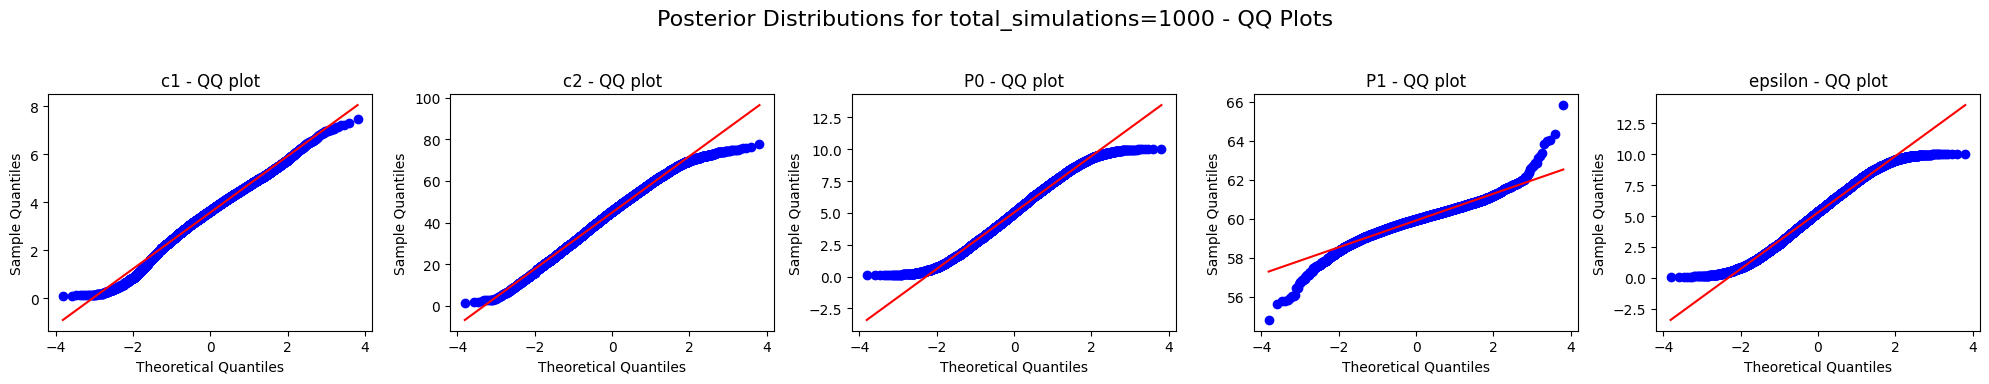

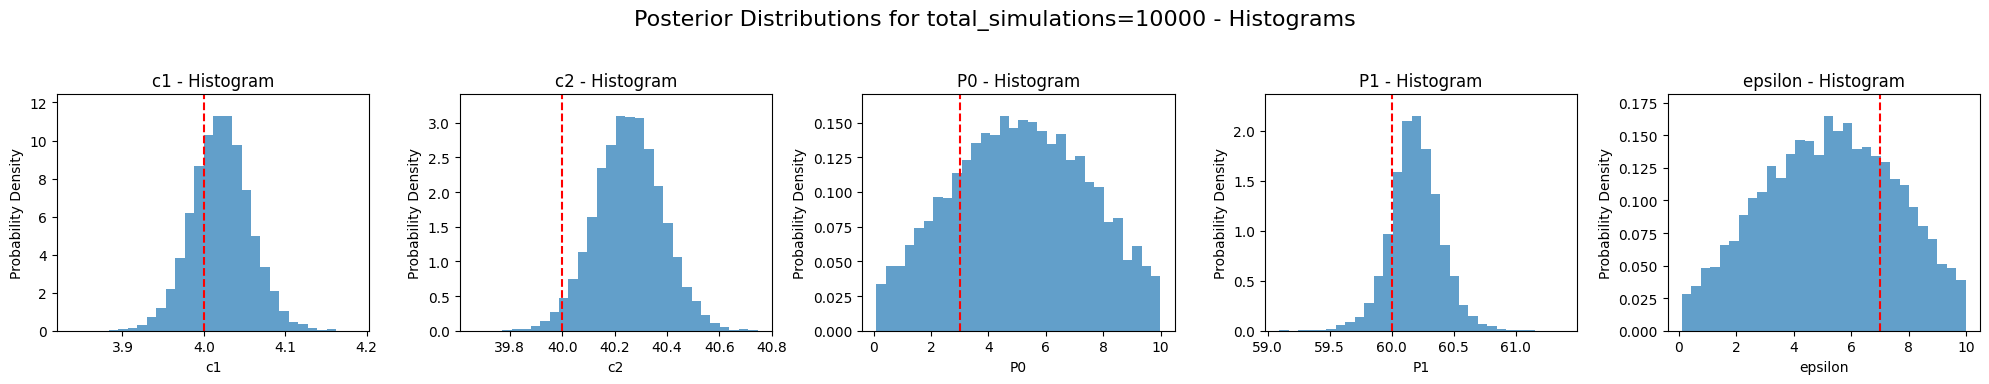

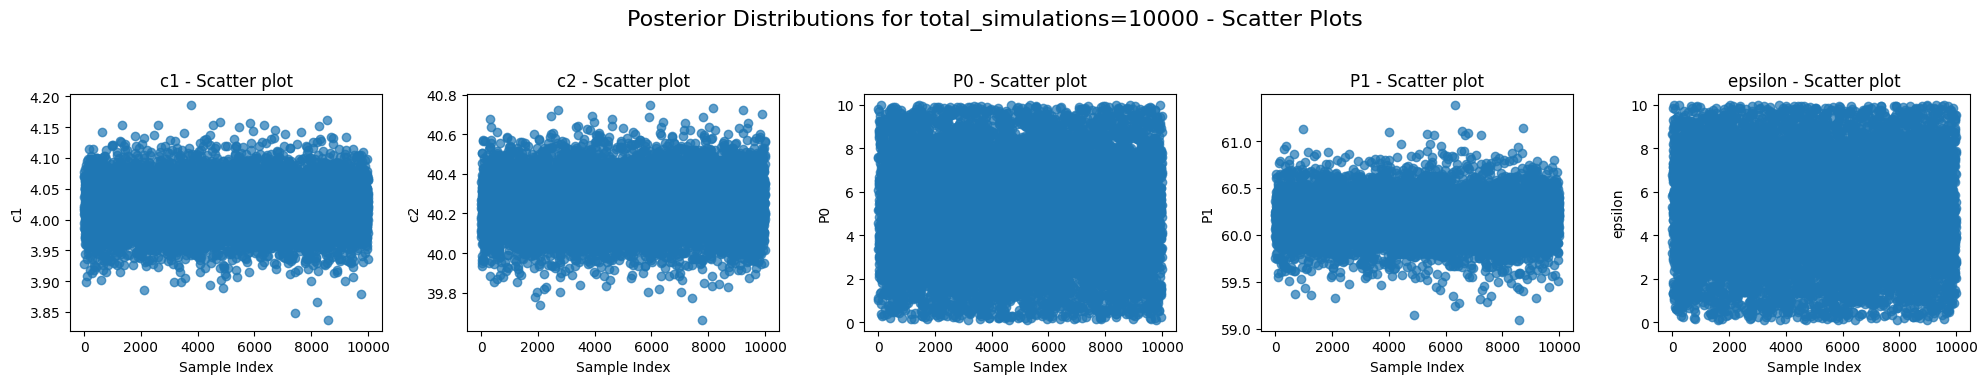

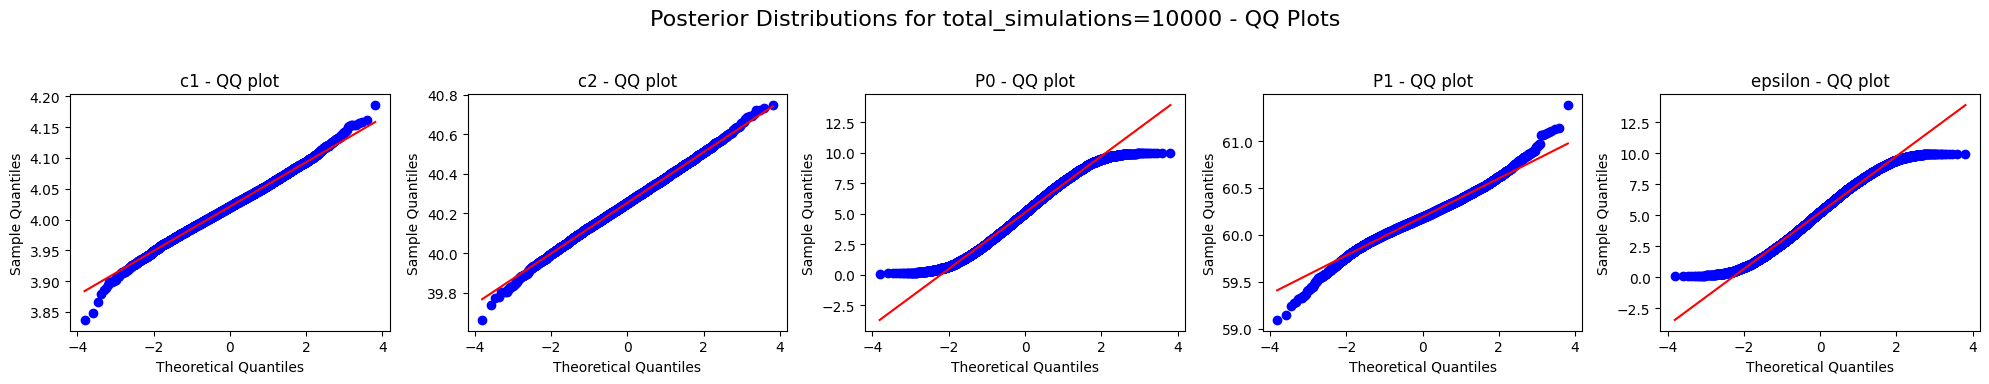

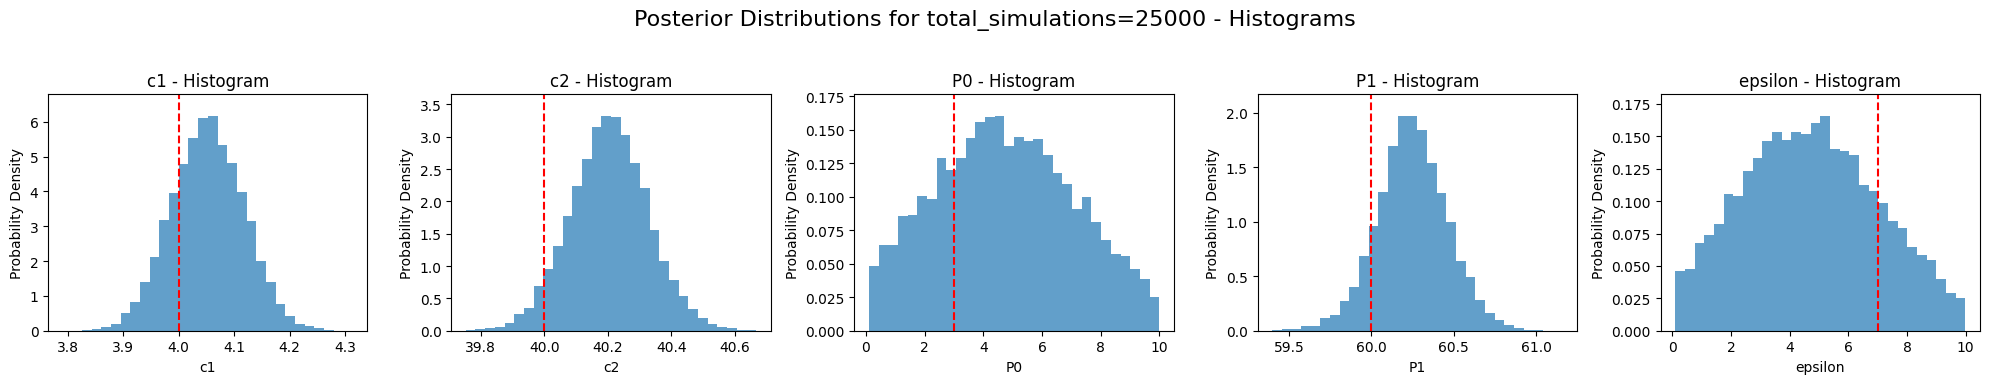

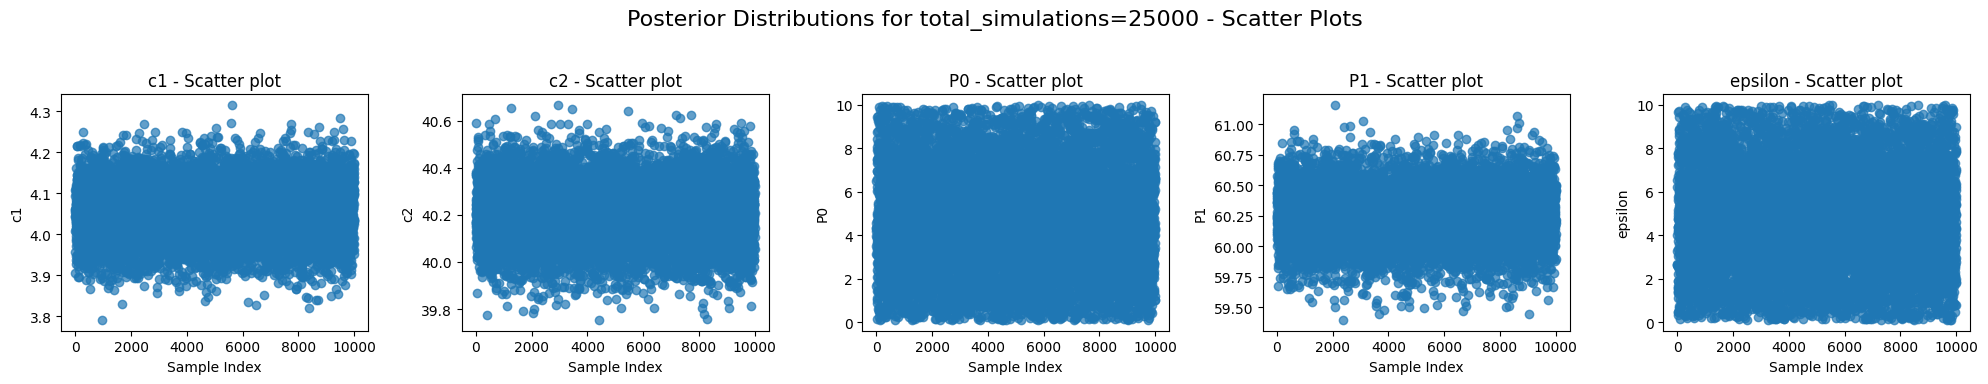

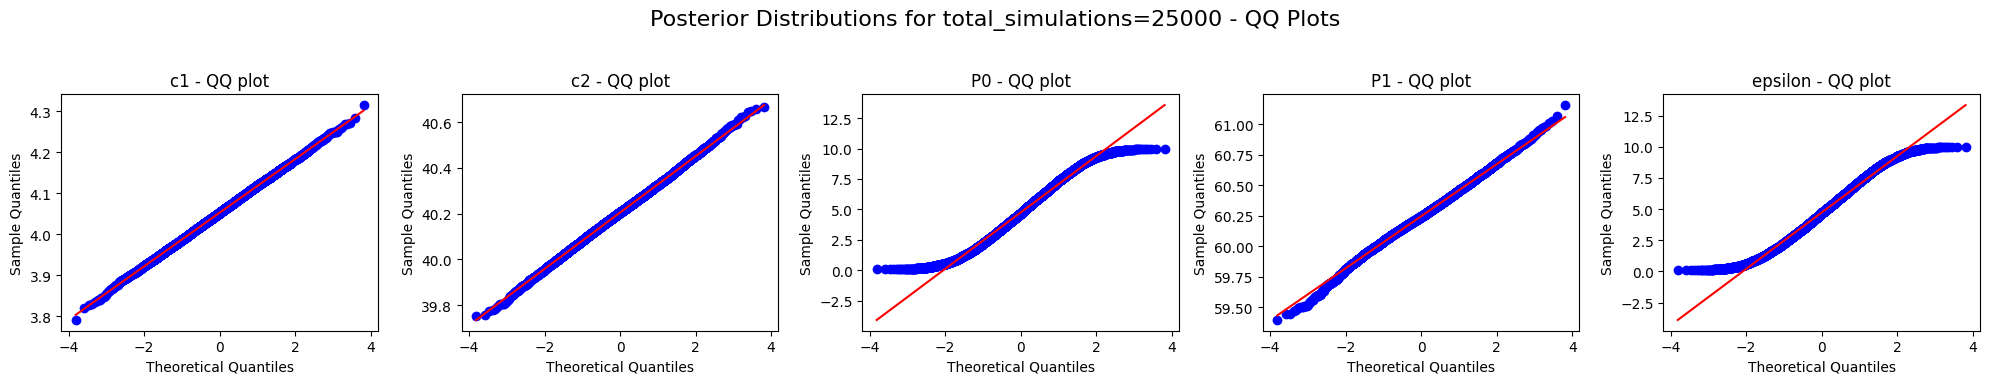

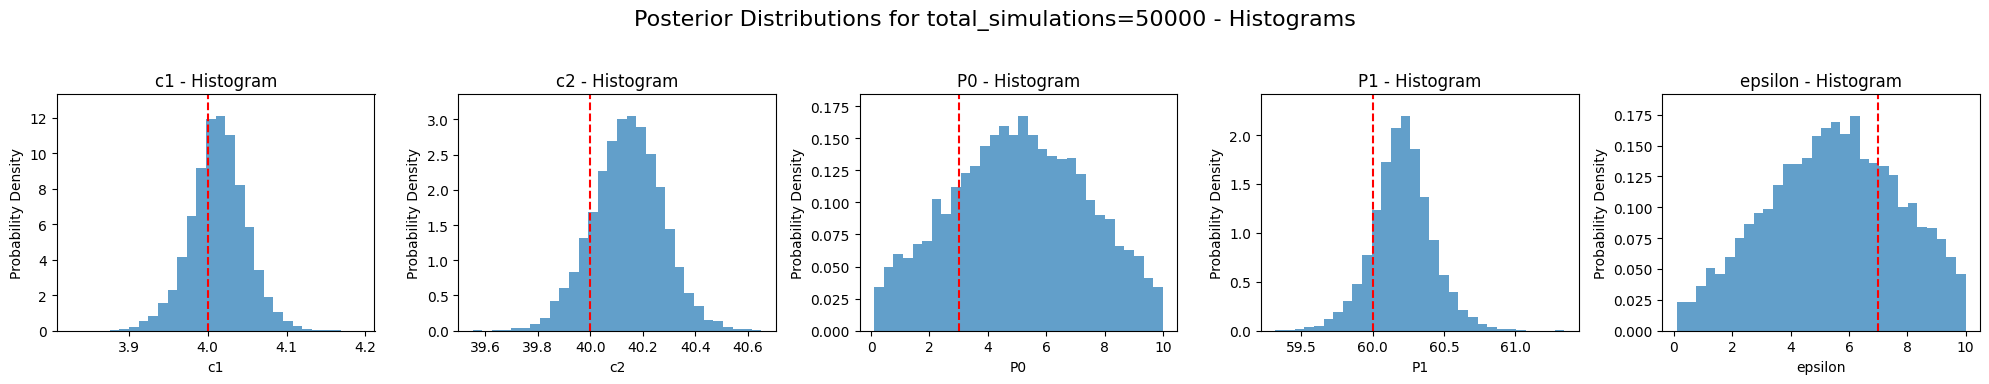

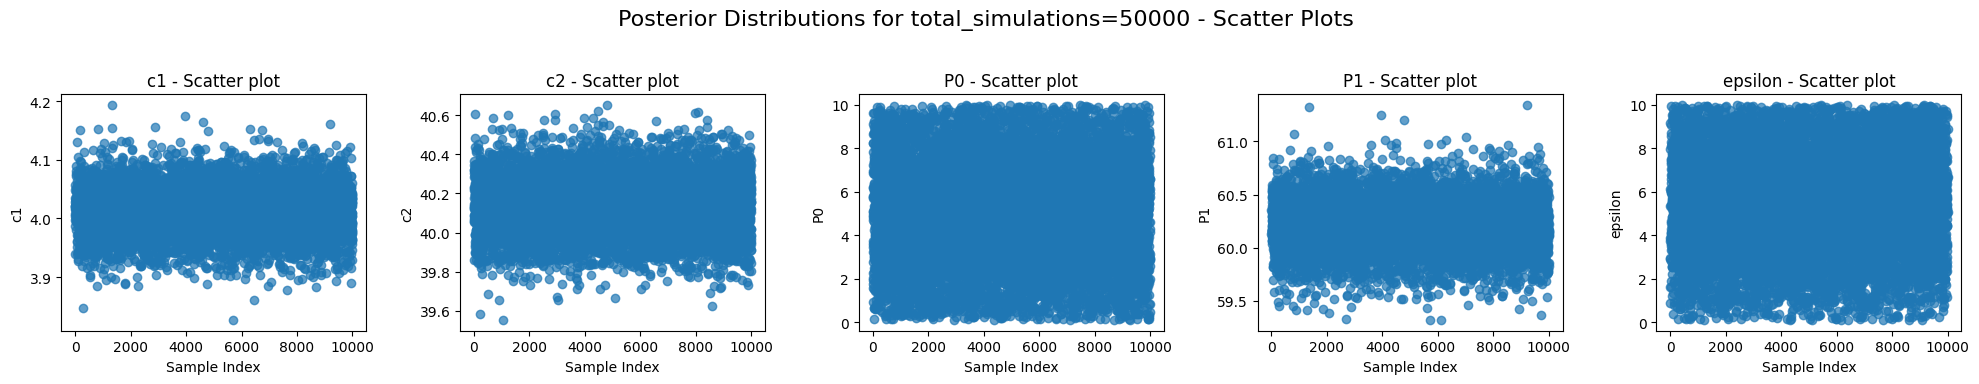

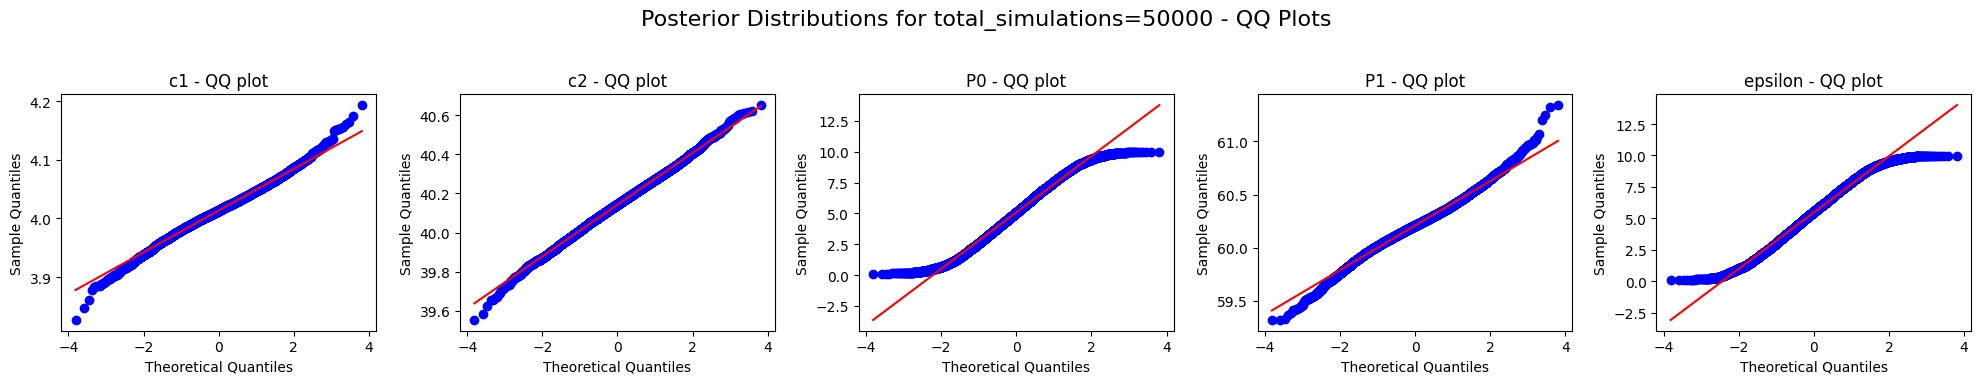

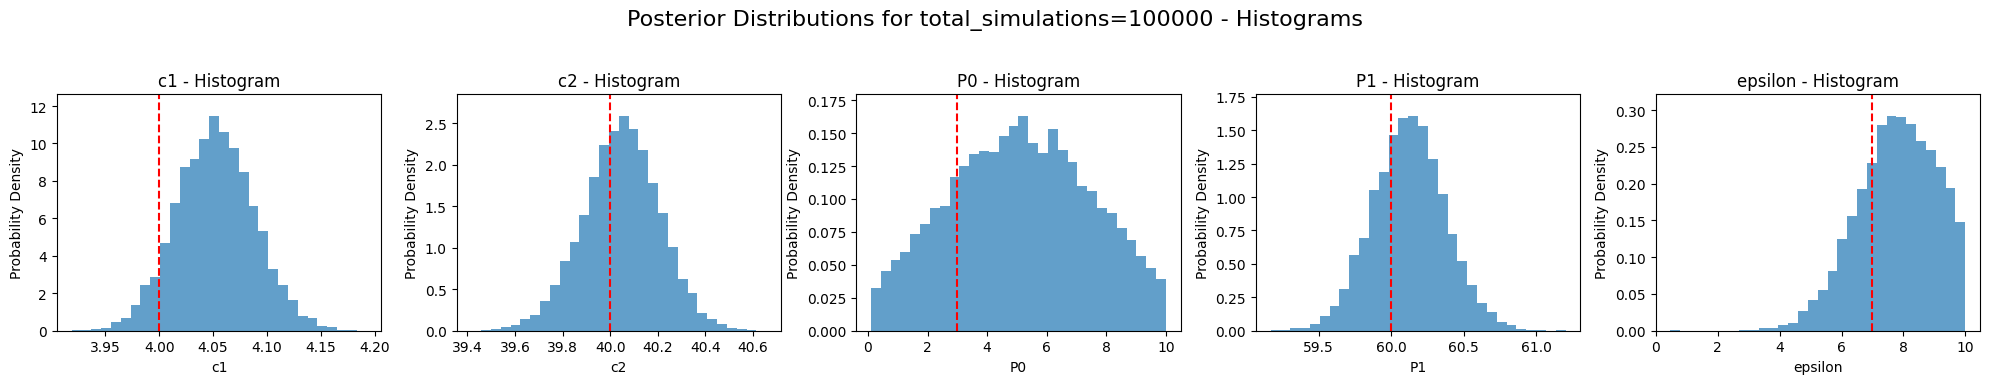

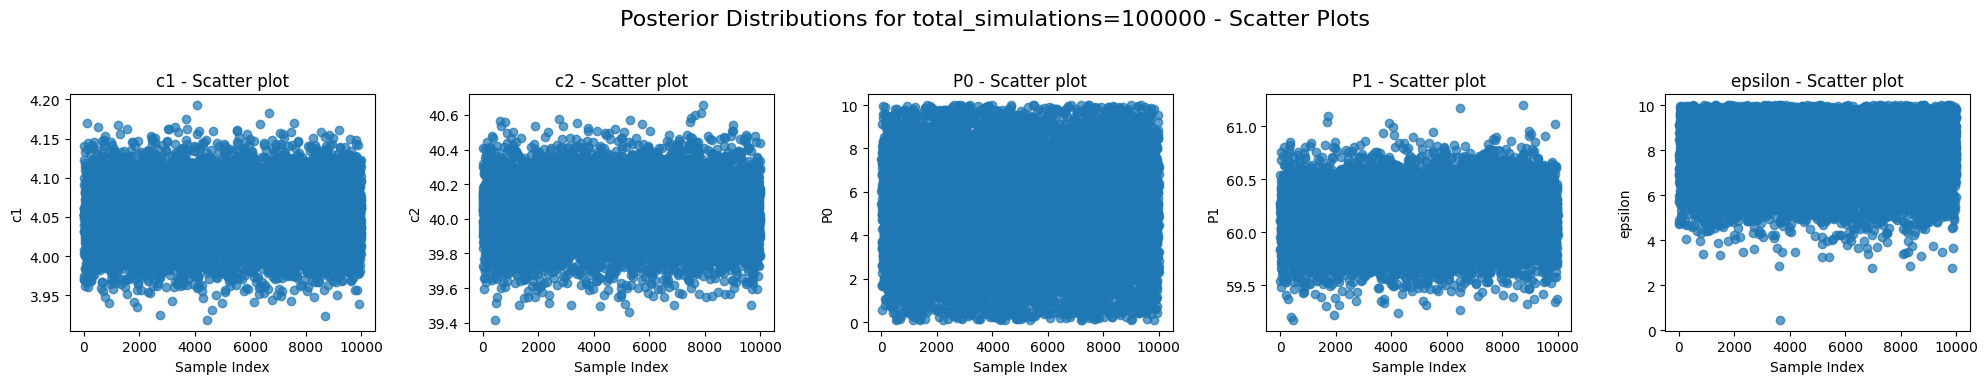

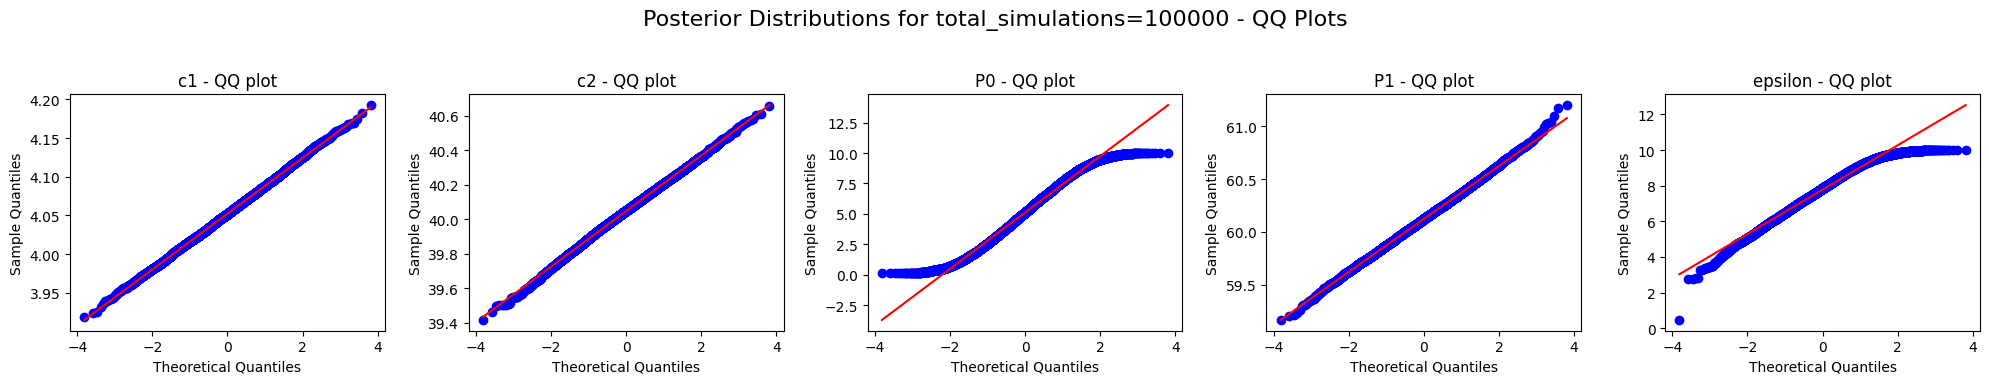

In [7]:
for posterior, total in posteriors:
    
    # Extract posterior distributions for current num_simulations
    posterior_samples = posterior.sample((10000,), show_progress_bars=False)

    # Create separate figures for each type of plot
    fig1, axes1 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig2, axes2 = plt.subplots(1, len(param_names), figsize=(20, 4))
    fig3, axes3 = plt.subplots(1, len(param_names), figsize=(20, 4))

    # Plot each parameter for current num_simulations
    for j, param_name in enumerate(param_names):
        parameter_samples = posterior_samples[:, j]
        
        # Histogram
        counts, bins, _ = axes1[j].hist(parameter_samples, bins=30, density=True, alpha=0.7, label='Inferred')
        axes1[j].axvline(x=theta_true[j], color='red', linestyle='--', label='True')
        axes1[j].set_title(param_name + ' - Histogram')
        axes1[j].set_ylabel('Probability Density')
        axes1[j].set_xlabel(param_name)
        
        # Scale the y-axis to span from 0% to 100%
        axes1[j].set_ylim(0, max(counts) * 1.1)  

        # Scatter plot
        axes2[j].scatter(range(len(parameter_samples)), parameter_samples, alpha=0.7)
        axes2[j].set_title(param_name + ' - Scatter plot')
        axes2[j].set_ylabel(param_name)
        axes2[j].set_xlabel('Sample Index')
        
        # QQ plot
        stats.probplot(parameter_samples, dist="norm", plot=axes3[j])
        axes3[j].set_title(param_name + ' - QQ plot')
        axes3[j].set_xlabel('Theoretical Quantiles')
        axes3[j].set_ylabel('Sample Quantiles')

    # Set titles for the figures
    fig1.suptitle(f'Posterior Distributions for total_simulations={total} - Histograms', fontsize=16)
    fig2.suptitle(f'Posterior Distributions for total_simulations={total} - Scatter Plots', fontsize=16)
    fig3.suptitle(f'Posterior Distributions for total_simulations={total} - QQ Plots', fontsize=16)

    # Adjust layout and save the figures
    fig1.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig1.savefig(os.path.join(dir_path_plots, f'histogram_{total}.pdf'))
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.savefig(os.path.join(dir_path_plots, f'scatter_{total}.pdf'))
    fig3.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig3.savefig(os.path.join(dir_path_plots, f'qqplot_{total}.pdf'))

    plt.show()

In [8]:
# Initialize lists to store the results
medians = []
stds = []
kurtoses = []
skews = []

# Calculate the statistics for each posterior
for posterior, total in posteriors:
    samples = posterior.sample((10000,), show_progress_bars=False)
    samples_np = samples.numpy()
    median = np.median(samples_np, axis=0)
    std = np.std(samples_np, axis=0)
    kurt = kurtosis(samples_np, axis=0)
    skewness = skew(samples_np, axis=0)
    
    medians.append([total] + list(median))
    stds.append([total] + list(std)) 
    kurtoses.append([total] + list(kurt))
    skews.append([total] + list(skewness))

# Create a DataFrame for each statistic
df_medians = pd.DataFrame(medians, columns=['total_simulations'] + param_names)
df_medians.set_index('total_simulations', inplace=True)

df_stds = pd.DataFrame(stds, columns=['total_simulations'] + param_names)
df_stds.set_index('total_simulations', inplace=True)

df_kurtoses = pd.DataFrame(kurtoses, columns=['total_simulations'] + param_names)
df_kurtoses.set_index('total_simulations', inplace=True)

df_skews = pd.DataFrame(skews, columns=['total_simulations'] + param_names)
df_skews.set_index('total_simulations', inplace=True)

# Save the DataFrames as CSV files in the specified directory
df_medians.to_csv(os.path.join(dir_path_tables, 'medians.csv'))
df_stds.to_csv(os.path.join(dir_path_tables, 'standard_deviations.csv'))
df_kurtoses.to_csv(os.path.join(dir_path_tables, 'kurtoses.csv'))
df_skews.to_csv(os.path.join(dir_path_tables, 'skews.csv'))

# Print the tables
print("Medians:")
print(df_medians)
print("\nStandard Deviations:")
print(df_stds)
print("\nKurtoses:")
print(df_kurtoses)
print("\nSkews:")
print(df_skews)

Medians:
                         c1         c2        P0         P1   epsilon
total_simulations                                                    
100                4.086265  44.288002  4.563133  60.224934  4.625443
1000               3.657481  45.303497  5.016023  59.939259  5.322137
10000              4.020624  40.255371  5.133945  60.183739  5.245643
25000              4.052430  40.201885  4.675957  60.246811  4.687530
50000              4.013641  40.142967  5.089631  60.203564  5.610917
100000             4.050991  40.051132  5.063357  60.122616  7.856233

Standard Deviations:
                         c1         c2        P0        P1   epsilon
total_simulations                                                   
100                0.395060  14.000164  2.006255  1.170301  2.138662
1000               1.171884  13.562286  2.238145  0.698774  2.289665
10000              0.036084   0.126194  2.316259  0.203666  2.302069
25000              0.065357   0.123380  2.344882  0.214351  2.27